In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy
from numba import jit

In [1]:
import sympy as sp
sp.init_printing()

In [3]:
sp_t = sp.symbols('t', real=True) #sp_theta = sp.Function('theta', real=True)(sp_t)
sp_f_ref =sp.sin(sp_t)**2 #sp.sin(sp_t)
sp_f_ref,sp.diff(sp_f_ref,sp_t),sp.diff(sp_f_ref,sp_t,2)

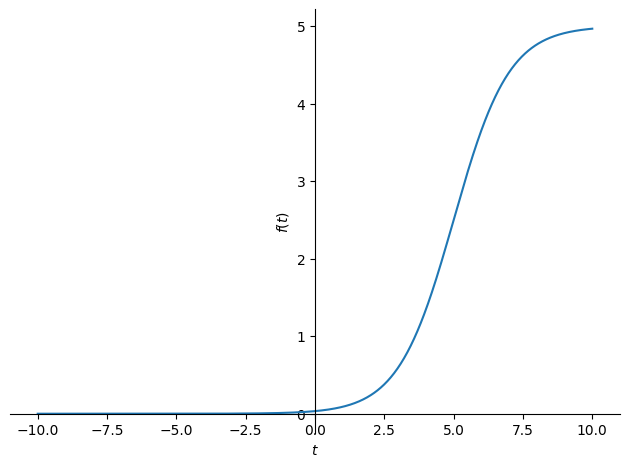

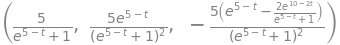

In [37]:
sp_f_ref = 1/(1 + sp.exp(-sp_t + 5)) * 5
sp.plot(sp_f_ref,(sp_t,-10,10))
sp_f_ref,sp.diff(sp_f_ref,sp_t),sp.diff(sp_f_ref,sp_t,2)

In [38]:
print( sp_f_ref) 
print( sp.diff(sp_f_ref,sp_t))
print( sp.diff(sp_f_ref,sp_t,2))    

5/(exp(5 - t) + 1)
5*exp(5 - t)/(exp(5 - t) + 1)**2
-5*(exp(5 - t) - 2*exp(10 - 2*t)/(exp(5 - t) + 1))/(exp(5 - t) + 1)**2


In [1]:
class ExtendedKalmanFilter:
    def __init__(self, x0, P0, Q, R):
        self.x = x0  # Estado inicial
        self.P = P0  # Covarianza inicial
        self.Q = Q   # Covarianza del ruido del proceso
        self.R = R   # Covarianza del ruido de medición
        
    def f(self, x, u):
        """Modelo no lineal del sistema"""
        theta, theta_dot = x
        dtheta = theta_dot
        dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2)
        return np.array([theta + T*dtheta, theta_dot + T*dtheta_dot])
    
    def h(self, x):
        """Función de medición"""
        return x
    
    def F_jacobian(self, x, u):
        """Jacobiano del modelo del sistema"""
        theta, theta_dot = x
        F = np.array([[1, T],
                     [-T*m*g*l*np.cos(theta)/(m*l**2), 1 - T*b/(m*l**2)]])
        return F
    
    def H_jacobian(self, x):
        """Jacobiano de la medición"""
        return np.eye(2)
    
    def predict(self, u):
        # Predicción del estado
        self.x = self.f(self.x, u)
        
        # Predicción de la covarianza
        F = self.F_jacobian(self.x, u)
        self.P = F @ self.P @ F.T + self.Q
        
        return self.x
    
    def update(self, z):
        # Calcular Jacobiano de medición
        H = self.H_jacobian(self.x)
        
        # Innovación
        y = z - self.h(self.x)
        
        # Covarianza de la innovación
        S = H @ self.P @ H.T + self.R
        
        # Ganancia de Kalman
        K = self.P @ H.T @ np.linalg.inv(S)
        
        # Actualización del estado
        self.x = self.x + K @ y
        
        # Actualización de la covarianza
        self.P = (np.eye(2) - K @ H) @ self.P
        
        return self.x

In [22]:
# Clase para el Filtro de Partículas
class ParticleFilter:
    def __init__(self, n_particles, x0, Q):
        self.n_particles = n_particles
        self.Q = Q
        
        # Inicializar partículas
        self.particles = np.tile(x0, (n_particles, 1)) + \
                        np.random.multivariate_normal(np.zeros(2), Q, n_particles)
        self.weights = np.ones(n_particles) / n_particles
        
    def f(self, x, u):
        """Modelo no lineal del sistema"""
        theta, theta_dot = x
        dtheta = theta_dot
        dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2)
        return np.array([theta + T*dtheta, theta_dot + T*dtheta_dot])
    
    def predict(self, u):
        # Propagar partículas
        for i in range(self.n_particles):
            self.particles[i] = self.f(self.particles[i], u)
            self.particles[i] += np.random.multivariate_normal(np.zeros(2), self.Q)
        
        return np.average(self.particles, weights=self.weights, axis=0)
    
    def update(self, z, R):
        # Actualizar pesos
        for i in range(self.n_particles):
            diff = z - self.particles[i]
            self.weights[i] *= np.exp(-0.5 * diff.T @ np.linalg.inv(R) @ diff)
            
        # Normalizar pesos
        self.weights /= np.sum(self.weights)
        
        # Resampling
        if 1.0 / np.sum(self.weights**2) < self.n_particles/2:
            indices = np.random.choice(self.n_particles, self.n_particles, p=self.weights)
            self.particles = self.particles[indices]
            self.weights = np.ones(self.n_particles) / self.n_particles
            
        return np.average(self.particles, weights=self.weights, axis=0)

In [23]:
class ParticleFilter:
    def __init__(self, n_particles, x0, Q):
        self.n_particles = n_particles
        self.Q = Q
        
        # Inicializar partículas usando operación vectorizada
        self.particles = np.random.multivariate_normal(x0, Q, n_particles)
        self.weights = np.ones(n_particles) / n_particles
        
        # Preparar matrices para cálculos
        self.R_inv = np.linalg.inv(R)  # Calcular una vez
        
    @staticmethod
    @jit(nopython=True)  # Acelerar función del modelo
    def f(x, u):
        """Modelo no lineal del sistema vectorizado"""
        theta = x[:, 0]
        theta_dot = x[:, 1]
        
        dtheta = theta_dot
        dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2)
        
        result = np.empty((x.shape[0], 2))
        result[:, 0] = theta + T * dtheta
        result[:, 1] = theta_dot + T * dtheta_dot
        return result
    
    def predict(self, u):
        # Propagar todas las partículas de una vez
        self.particles = self.f(self.particles, u)
        
        # Añadir ruido vectorizado
        self.particles += np.random.multivariate_normal(
            np.zeros(2), 
            self.Q, 
            self.n_particles
        )
        
        # Retornar estimación ponderada
        return np.average(self.particles, weights=self.weights, axis=0)
    
    def update(self, z, R):
        # Calcular diferencias para todas las partículas de una vez
        diff = z - self.particles  # Shape: (n_particles, 2)
        
        # Calcular productos matriciales vectorizados
        quad_term = np.sum(diff @ self.R_inv * diff, axis=1)
        
        # Actualizar pesos usando operación vectorizada
        log_weights = -0.5 * quad_term
        weights_new = np.exp(log_weights - np.max(log_weights))  # Evitar underflow
        
        # Normalizar pesos
        self.weights = weights_new / np.sum(weights_new)
        
        # Calcular número efectivo de partículas
        N_eff = 1.0 / np.sum(np.square(self.weights))
        
        # Resampling sistemático cuando sea necesario
        if N_eff < self.n_particles/2:
            cumsum = np.cumsum(self.weights)
            cumsum[-1] = 1.0  # Evitar errores de redondeo
            
            # Generar puntos de muestreo uniformes
            positions = (np.random.random() + np.arange(self.n_particles)) / self.n_particles
            
            # Encontrar índices usando searchsorted vectorizado
            indices = np.searchsorted(cumsum, positions)
            
            # Realizar resampling
            self.particles = self.particles[indices]
            self.weights[:] = 1.0 / self.n_particles  # Asignación vectorizada
        
        return np.average(self.particles, weights=self.weights, axis=0)

    def get_state_distribution(self):
        """Retorna media y covarianza del estado estimado"""
        mean = np.average(self.particles, weights=self.weights, axis=0)
        cov = np.cov(self.particles.T, aweights=self.weights)
        return mean, cov


In [34]:


# Parámetros del sistema
m = 1.0     # masa (kg)
l = 1.0     # longitud (m)
g = 9.81    # gravedad (m/s²)
b = 0.1     # fricción (N⋅m⋅s/rad)


# Parámetros de simulación
T = 0.01    # período de muestreo (s)
t_final = 10  # tiempo final de simulación (s)
k_steps = int(t_final/T)  # número de pasos
n_edos = 2  # número de ecuaciones diferenciales

# Vectores para almacenar resultados
t = np.arange(0, t_final, T)  # vector de tiempo

# Sistema sin ruido
theta = np.zeros(k_steps)      # ángulo
theta_dot = np.zeros(k_steps)  # velocidad angular
# Sistema sin ruido medicion
theta_ruido_medicion = np.zeros(k_steps)      # ángulo
theta_ruido_medicion_dot = np.zeros(k_steps)  # velocidad angular
# Sistema con ruido de proceso
theta_ruido_proceso = np.zeros(k_steps)      # ángulo
theta_ruido_proceso_dot = np.zeros(k_steps)  # velocidad angular
# Sistema con ruido de proceso y medicion 
theta_ruido_medicion_proceso = np.zeros(k_steps)      # ángulo
theta_ruido_medicion_proceso_dot = np.zeros(k_steps)  # velocidad angular
# Sistema con EKF 
theta_ekf = np.zeros(k_steps)
theta_ekf_dot = np.zeros(k_steps)
theta_ekf_sistema = np.zeros(k_steps)
theta_ekf_sistema_dot = np.zeros(k_steps)
# Sistema con PF
theta_pf = np.zeros(k_steps)
theta_pf_dot = np.zeros(k_steps)
theta_pf_sistema = np.zeros(k_steps)
theta_pf_sistema_dot = np.zeros(k_steps)

# Condiciones iniciales
theta[0] = np.pi/4    # 45 grados
theta_dot[0] = 0      # velocidad inicial cero
theta_ruido_medicion[0] = np.pi/4    # 45 grados
theta_ruido_medicion_dot[0] = 0      # velocidad inicial cero
theta_ruido_proceso[0] = np.pi/4    # 45 grados
theta_ruido_proceso_dot[0] = 0      # velocidad inicial cero
theta_ruido_medicion_proceso[0] = np.pi/4    # 45 grados
theta_ruido_medicion_proceso_dot[0] = 0      # velocidad inicial cero
theta_ekf[0] = np.pi/4    # 45 grados
theta_ekf_dot[0] = 0      # velocidad inicial cero
theta_ekf_sistema[0] = np.pi/4    # 45 grados
theta_ekf_sistema_dot[0] = 0      # velocidad inicial cero
theta_pf[0] = np.pi/4    # 45 grados
theta_pf_dot[0] = 0      # velocidad inicial cero
theta_pf_sistema[0] = np.pi/4    # 45 grados
theta_pf_sistema_dot[0] = 0      # velocidad inicial cero

# Calcular referencia
theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 



# Inicialización de filtros
x0 = np.array([np.pi/4, 0])
P0 = np.diag([0.1, 0.1])
Q = np.diag([0.001, 0.001])  # Covarianza del ruido del proceso
R = np.diag([0.04, 0.04])    # Covarianza del ruido de medición

ekf = ExtendedKalmanFilter(x0, P0, Q, R)
pf = ParticleFilter(n_particles=1000, x0=x0, Q=Q)

# Vectores para almacenar estimaciones


# Inicialización
x0 = np.array([np.pi/4, 0])
Q = np.diag([0.001, 0.001])
R = np.diag([0.04, 0.04])
pf = ParticleFilter(n_particles=1000, x0=x0, Q=Q)


def control_retroalimentacion(estado, t):
    #theta_ref = np.sin(t)
    #dtheta_ref = np.cos(t)  
    #ddtheta_ref = -np.sin(t)  
    theta_ref = 1/(np.exp(5 - t) + 1) #np.sin(t)
    dtheta_ref = np.exp(5 - t)/(np.exp(5 - t) + 1)**2 #np.cos(t)
    ddtheta_ref = (-np.exp(5 - t) + 2*np.exp(10 - 2*t)/(np.exp(5 - t) + 1))/(np.exp(5 - t) + 1)**2 #-np.sin(t) 
    
    theta,dtheta = estado+ np.random.normal(0,0.002,(estado.shape) )
    k1,k2 = 10,20 #2,1
    
    e = theta - theta_ref  # Error
    de = dtheta - dtheta_ref  # Derivada del error

    u = m*l**2*( ddtheta_ref - k1*(de) -k2*(e) + (b/(m*l**2))*dtheta + (g/l)*np.sin(theta) )  # Control
    return u  

def system (x,u,ruido=0):
    theta = x[0]
    theta_dot = x[1]

    dtheta = theta_dot + ruido[0]
    dtheta_dot = (-b*theta_dot - m*g*l*np.sin(theta) + u)/(m*l**2) + ruido[1]

    theta_k1 = theta + T*dtheta
    theta_dot_k1 = theta_dot + T*dtheta_dot

    return np.array([theta_k1, theta_dot_k1])


np.random.seed(158)
ruido_medicion = cauchy.rvs(loc=0, scale=0.01, size=(k_steps,n_edos)) #np.random.normal(0,0.1,(k_steps,n_edos) )
ruido_medicion_proceso = cauchy.rvs(loc=0, scale=0.05, size=(k_steps,n_edos)) #np.random.normal(0,0.15,(k_steps,n_edos) )

#ruido_medicion = np.random.normal(0,0.1,(k_steps,n_edos) )
#ruido_medicion_proceso = np.random.normal(0,0.15,(k_steps,n_edos) )

# Simulación usando método de Euler
for k in range(k_steps-1):
    # Entrada de control (en este caso 0 para oscilación libre)
    #u = 0#control_retroalimentacion([theta[k], theta_dot[k]], t[k])

    # Sistema sin ruido
    x = np.array([theta[k], theta_dot[k]])
    z = x
    u = control_retroalimentacion(z, t[k])
    theta[k+1], theta_dot[k+1] = system([theta[k], theta_dot[k]], u, [0,0] )

    # Sistema con ruido de medicion 
    x = np.array([theta_ruido_medicion[k], theta_ruido_medicion_dot[k]])
    z = x + ruido_medicion[k,:]
    u = control_retroalimentacion(z, t[k])
    theta_ruido_medicion[k+1], theta_ruido_medicion_dot[k+1] = system([theta_ruido_medicion[k], theta_ruido_medicion_dot[k]], u, [0,0] )

    # Sistema con ruido de proceso
    x = np.array([theta_ruido_proceso[k], theta_ruido_proceso_dot[k]])
    z = x 
    u = control_retroalimentacion(z, t[k])
    theta_ruido_proceso[k+1], theta_ruido_proceso_dot[k+1] = system([theta_ruido_proceso[k], theta_ruido_proceso_dot[k]], u, ruido_medicion_proceso[k,:] )

    # Sistema con ruido de meidcion y proceso
    x = np.array([theta_ruido_medicion_proceso[k], theta_ruido_medicion_proceso_dot[k]])
    z = x + ruido_medicion[k,:]
    u = control_retroalimentacion(z, t[k])
    theta_ruido_medicion_proceso[k+1], theta_ruido_medicion_proceso_dot[k+1] = system([theta_ruido_medicion_proceso[k], theta_ruido_medicion_proceso_dot[k]], u, ruido_medicion_proceso[k,:] )

    # EKF
    x_est = np.array([theta_ekf[k], theta_ekf_dot[k]])
    z = x_est 
    u = control_retroalimentacion(z, t[k])
    
    ekf.predict(u)
    x_sistema = np.array([theta_ekf_sistema[k], theta_ekf_sistema_dot[k]])

    x = np.array([theta_ekf_sistema[k], theta_ekf_sistema_dot[k]])
    z = x + ruido_medicion[k,:]
    x_ekf = ekf.update(z)
    theta_ekf_sistema[k+1], theta_ekf_sistema_dot[k+1] = system([theta_ekf_sistema[k], theta_ekf_sistema_dot[k]], u, ruido_medicion_proceso[k,:] )
    theta_ekf[k+1], theta_ekf_dot[k+1] = x_ekf
    
    # Partículas
    x = np.array([theta_pf[k], theta_pf_dot[k]])
    z = x
    u = control_retroalimentacion(z, t[k])
    x_pf = pf.predict(u)

    x_pf = pf.update(z, R)
    
    x = np.array([theta_pf_sistema[k], theta_pf_sistema_dot[k]])
    z = x + ruido_medicion[k,:]
    x_pf = ekf.update(z)
    theta_pf_sistema[k+1], theta_pf_sistema_dot[k+1] = system([theta_pf_sistema[k], theta_pf_sistema_dot[k]], u, ruido_medicion_proceso[k,:] )
    theta_pf[k+1], theta_pf_dot[k+1] = x_pf
    
    

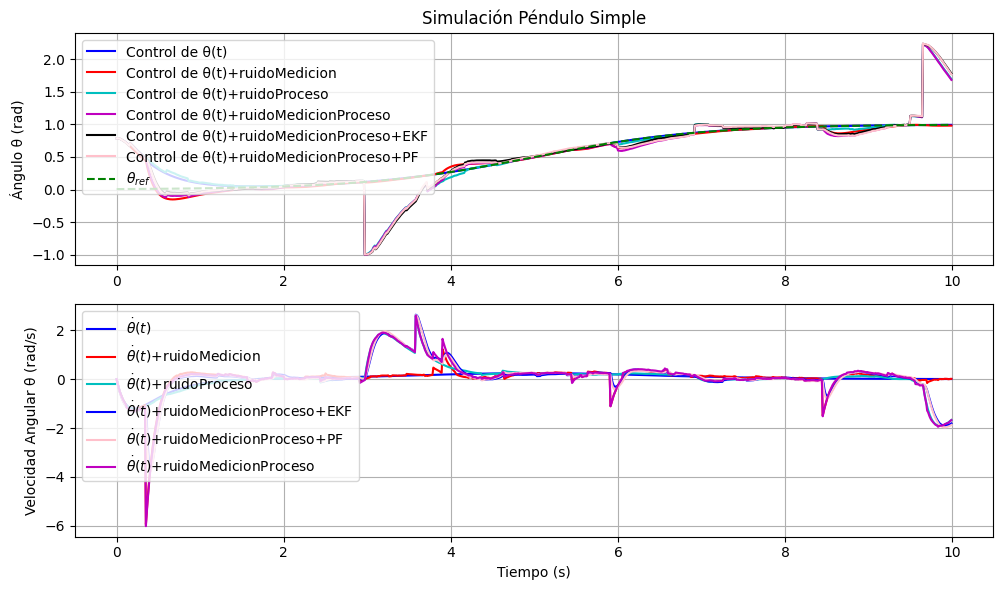

In [35]:
# Graficar resultados
plt.figure(figsize=(10, 6))

# Gráfica del ángulo
plt.subplot(2,1,1)
plt.plot(t, theta, 'b-', label='Control de θ(t)')
plt.plot(t, theta_ruido_medicion, 'r-', label='Control de θ(t)+ruidoMedicion')
plt.plot(t, theta_ruido_proceso, 'c-', label='Control de θ(t)+ruidoProceso')
plt.plot(t, theta_ruido_medicion_proceso, 'm-', label='Control de θ(t)+ruidoMedicionProceso')
plt.plot(t, theta_ekf_sistema, 'k-', label='Control de θ(t)+ruidoMedicionProceso+EKF')
plt.plot(t, theta_pf_sistema, '-', color='pink', label='Control de θ(t)+ruidoMedicionProceso+PF')
plt.plot(t, theta_ref, 'g--',label='$θ_{ref}$')

plt.legend(['θ','θ+ruido', '$θ_{ref}$'])
plt.grid(True)
plt.ylabel('Ángulo θ (rad)')
plt.title('Simulación Péndulo Simple')
plt.legend()

# Gráfica de la velocidad angular
plt.subplot(2,1,2)
plt.plot(t, theta_dot, 'b-', label='$\\dot{θ̇}(t)$')
plt.plot(t, theta_ruido_medicion_dot, 'r-', label='$\\dot{θ̇}(t)$+ruidoMedicion')
plt.plot(t, theta_ruido_proceso_dot, 'c-', label='$\\dot{θ̇}(t)$+ruidoProceso')
plt.plot(t, theta_ekf_sistema_dot, 'b', label='$\\dot{θ̇}(t)$+ruidoMedicionProceso+EKF')
plt.plot(t, theta_pf_sistema_dot, '-', color='pink', label='$\\dot{θ̇}(t)$+ruidoMedicionProceso+PF')
plt.plot(t, theta_ruido_medicion_proceso_dot, 'm-', label='$\\dot{θ̇}(t)$+ruidoMedicionProceso')


plt.grid(True)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Angular θ̇ (rad/s)')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
import plotly.graph_objects as go

# Sistema con ruido

In [36]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Crear los subplots
fig = make_subplots(rows=2, cols=1, 
                   subplot_titles=('Ángulo del Péndulo', 'Velocidad Angular'),
                   vertical_spacing=0.15)

# Gráfica del ángulo (primera subfigura)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta,
       name='θ',
       line=dict(color='blue'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion,
       name='θ+ruido medición',
       line=dict(color='red'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_proceso,
       name='θ+ruido proceso',
       line=dict(color='cyan'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_proceso,
       name='θ+ruido medición+proceso',
       line=dict(color='magenta'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ekf_sistema,
       name='θ+ruido medición+proceso+EKF',
       line=dict(color='black'),
       #legendgroup='1'
   ),
   row=1, col=1
)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_pf_sistema,
       name='θ+ruido medición+proceso+PF',
       line=dict(color='pink'),
       #legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ref,
       name='θ_ref',
       line=dict(color='green', dash='dash'),
       #legendgroup='1'
   ),
   row=1, col=1
)

# Gráfica de la velocidad angular (segunda subfigura)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_dot,
       name='ω',
       line=dict(color='blue'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_dot,
       name='ω+ruido medición',
       line=dict(color='red'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_proceso_dot,
       name='ω+ruido proceso',
       line=dict(color='cyan'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_proceso_dot,
       name='ω+ruido medición+proceso',
       line=dict(color='magenta'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ekf_sistema_dot,
       name='ω+ruido medición+proceso+EKF',
       line=dict(color='black'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_pf_sistema_dot,
       name='ω+ruido medición+proceso+PF',
       line=dict(color='pink'),
       #legendgroup='2',
       showlegend=True
   ),
   row=2, col=1
)

# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   ),
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Ángulo θ (rad)', row=1, col=1)
fig.update_yaxes(title_text='Velocidad Angular θ̇ (rad/s)', row=2, col=1)


# Mostrar la figura
fig.show()

In [ ]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [50]:


# Calcular posiciones x,y de los péndulos
l = 1.0  # longitud del péndulo

# Calcular posiciones para cada péndulo
x_pendulo = l * np.sin(theta)
y_pendulo = -l * np.cos(theta)

x_pendulo_ruido_med = l * np.sin(theta_ruido_medicion)
y_pendulo_ruido_med = -l * np.cos(theta_ruido_medicion)

x_pendulo_ruido_proc = l * np.sin(theta_ruido_proceso)
y_pendulo_ruido_proc = -l * np.cos(theta_ruido_proceso)

x_pendulo_ruido_med_proc = l * np.sin(theta_ruido_medicion_proceso)
y_pendulo_ruido_med_proc = -l * np.cos(theta_ruido_medicion_proceso)

# Crear figura con subplots
fig = make_subplots(
   rows=2, cols=2,
   subplot_titles=('Péndulo Sin Ruido', 'Péndulo con Ruido de Medición',
                  'Péndulo con Ruido de Proceso', 'Péndulo con Ruido de Medición y Proceso'),
   specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
          [{'type': 'scatter'}, {'type': 'scatter'}]]
)

# Crear frames para la animación
frames = []
for i in range(0,len(t),10):
   frame_data = [
       # Péndulo sin ruido
       go.Scatter(
           x=[0, x_pendulo[i]],
           y=[0, y_pendulo[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'blue']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Sin Ruido'
       ),
       
       # Péndulo con ruido de medición
       go.Scatter(
           x=[0, x_pendulo_ruido_med[i]],
           y=[0, y_pendulo_ruido_med[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'red']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Ruido Medición'
       ),
       
       # Péndulo con ruido de proceso
       go.Scatter(
           x=[0, x_pendulo_ruido_proc[i]],
           y=[0, y_pendulo_ruido_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'cyan']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Ruido Proceso'
       ),
       
       # Péndulo con ambos ruidos
       go.Scatter(
           x=[0, x_pendulo_ruido_med_proc[i]],
           y=[0, y_pendulo_ruido_med_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'magenta']),
           line=dict(color='black', width=2),
           showlegend=False,
           name='Ruido Med+Proc'
       )
   ]
   frames.append(go.Frame(data=frame_data, name=f'frame{i}'))

# Añadir trazos iniciales
# Péndulo sin ruido
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo[0]],
       y=[0, y_pendulo[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'blue']),
       line=dict(color='black', width=2),
       name='Sin Ruido'
   ),
   row=1, col=1
)

# Péndulo con ruido de medición
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med[0]],
       y=[0, y_pendulo_ruido_med[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'red']),
       line=dict(color='black', width=2),
       name='Ruido Medición'
   ),
   row=1, col=2
)

# Péndulo con ruido de proceso
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_proc[0]],
       y=[0, y_pendulo_ruido_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'cyan']),
       line=dict(color='black', width=2),
       name='Ruido Proceso'
   ),
   row=2, col=1
)

# Péndulo con ambos ruidos
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med_proc[0]],
       y=[0, y_pendulo_ruido_med_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'magenta']),
       line=dict(color='black', width=2),
       name='Ruido Med+Proc'
   ),
   row=2, col=2
)

# Actualizar layout
fig.update_layout(
   title='Simulación de Péndulos con Diferentes Tipos de Ruido',
   height=800,
   width=1000,
   showlegend=True,
   plot_bgcolor='white',
   updatemenus=[
       {
           "buttons": [
               {
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                 "fromcurrent": True}],
                   "label": "Play",
                   "method": "animate"
               },
               {
                   "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                   "mode": "immediate",
                                   "transition": {"duration": 0}}],
                   "label": "Pause",
                   "method": "animate"
               }
           ],
           "direction": "left",
           "pad": {"r": 10, "t": 10},
           "type": "buttons",
           "x": 0.1,
           "y": 0
       }
   ],
   sliders=[{
       "currentvalue": {"prefix": "Tiempo: "},
       "pad": {"b": 10, "t": 50},
       "len": 0.9,
       "x": 0.1,
       "y": 0,
       "steps": [
           {
               "args": [[f.name], {
                   "frame": {"duration": 0, "redraw": True},
                   "mode": "immediate",
                   "transition": {"duration": 0}
               }],
               "label": str(round(t[k], 2)),
               "method": "animate"
           } for k, f in enumerate(frames)
       ]
   }]
)

# Actualizar ejes para todas las subgráficas
for i in [1, 2]:
   for j in [1, 2]:
       fig.update_xaxes(range=[-1.5, 1.5], row=i, col=j, showgrid=True, gridcolor='LightGray')
       fig.update_yaxes(range=[-1.5, 1.5], row=i, col=j, showgrid=True, gridcolor='LightGray')
       fig.update_yaxes(scaleanchor=f'x{(i-1)*2 + j}', scaleratio=1, row=i, col=j)

# Actualizar frames
fig.frames = frames

# Mostrar figura
fig.show()

In [52]:
import plotly.graph_objects as go
import numpy as np

# Calcular posiciones x,y de los péndulos
l = 1.0  # longitud del péndulo

# Calcular posiciones para cada péndulo
x_pendulo = l * np.sin(theta)
y_pendulo = -l * np.cos(theta)

x_pendulo_ruido_med = l * np.sin(theta_ruido_medicion)
y_pendulo_ruido_med = -l * np.cos(theta_ruido_medicion)

x_pendulo_ruido_proc = l * np.sin(theta_ruido_proceso)
y_pendulo_ruido_proc = -l * np.cos(theta_ruido_proceso)

x_pendulo_ruido_med_proc = l * np.sin(theta_ruido_medicion_proceso)
y_pendulo_ruido_med_proc = -l * np.cos(theta_ruido_medicion_proceso)

# Crear figura
fig = go.Figure()

# Crear frames para la animación
frames = []
for i in range(0,len(t),10):
   frame_data = [
       # Péndulo sin ruido
       go.Scatter(
           x=[0, x_pendulo[i]],
           y=[0, y_pendulo[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'blue']),
           line=dict(color='black', width=2),
           name='Sin Ruido'
       ),
       
       # Péndulo con ruido de medición
       go.Scatter(
           x=[0, x_pendulo_ruido_med[i]],
           y=[0, y_pendulo_ruido_med[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'red']),
           line=dict(color='black', width=2),
           name='Ruido Medición'
       ),
       
       # Péndulo con ruido de proceso
       go.Scatter(
           x=[0, x_pendulo_ruido_proc[i]],
           y=[0, y_pendulo_ruido_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'cyan']),
           line=dict(color='black', width=2),
           name='Ruido Proceso'
       ),
       
       # Péndulo con ambos ruidos
       go.Scatter(
           x=[0, x_pendulo_ruido_med_proc[i]],
           y=[0, y_pendulo_ruido_med_proc[i]],
           mode='lines+markers',
           marker=dict(size=[10, 15], color=['black', 'magenta']),
           line=dict(color='black', width=2),
           name='Ruido Med+Proc'
       )
   ]
   frames.append(go.Frame(data=frame_data, name=f'frame{i}'))

# Añadir trazos iniciales
# Péndulo sin ruido
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo[0]],
       y=[0, y_pendulo[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'blue']),
       line=dict(color='black', width=2),
       name='Sin Ruido'
   )
)

# Péndulo con ruido de medición
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med[0]],
       y=[0, y_pendulo_ruido_med[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'red']),
       line=dict(color='black', width=2),
       name='Ruido Medición'
   )
)

# Péndulo con ruido de proceso
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_proc[0]],
       y=[0, y_pendulo_ruido_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'cyan']),
       line=dict(color='black', width=2),
       name='Ruido Proceso'
   )
)

# Péndulo con ambos ruidos
fig.add_trace(
   go.Scatter(
       x=[0, x_pendulo_ruido_med_proc[0]],
       y=[0, y_pendulo_ruido_med_proc[0]],
       mode='lines+markers',
       marker=dict(size=[10, 15], color=['black', 'magenta']),
       line=dict(color='black', width=2),
       name='Ruido Med+Proc'
   )
)

# Actualizar layout
fig.update_layout(
   title='Simulación del Péndulo Simple con Diferentes Tipos de Ruido',
   height=800,
   width=800,
   showlegend=True,
   plot_bgcolor='white',
   xaxis=dict(
       range=[-1.5, 1.5],
       showgrid=True,
       gridcolor='LightGray',
       zeroline=True,
       zerolinecolor='LightGray'
   ),
   yaxis=dict(
       range=[-1.5, 1.5],
       showgrid=True,
       gridcolor='LightGray',
       zeroline=True,
       zerolinecolor='LightGray',
       scaleanchor='x',
       scaleratio=1
   ),
   updatemenus=[
       {
           "buttons": [
               {
                   "args": [None, {"frame": {"duration": 50, "redraw": True},
                                 "fromcurrent": True}],
                   "label": "Play",
                   "method": "animate"
               },
               {
                   "args": [[None], {"frame": {"duration": 0, "redraw": True},
                                   "mode": "immediate",
                                   "transition": {"duration": 0}}],
                   "label": "Pause",
                   "method": "animate"
               }
           ],
           "direction": "left",
           "pad": {"r": 10, "t": 10},
           "type": "buttons",
           "x": 0.1,
           "y": 0
       }
   ],
   sliders=[{
       "currentvalue": {
           "prefix": "Tiempo: ",
           "suffix": " s",
           "visible": True,
           "xanchor": "right"
       },
       "pad": {"b": 10, "t": 50},
       "len": 0.9,
       "x": 0.1,
       "y": 0,
       "steps": [
           {
               "args": [[f.name], {
                   "frame": {"duration": 0, "redraw": True},
                   "mode": "immediate",
                   "transition": {"duration": 0}
               }],
               "label": f"{t[k]:.2f}",
               "method": "animate"
           } for k, f in enumerate(frames)
       ]
   }]
)

# Añadir referencia del ángulo deseado
for i in range(len(frames)):
   frames[i].data += (
       go.Scatter(
           x=[0, l*np.sin(theta_ref[i])],
           y=[0, -l*np.cos(theta_ref[i])],
           mode='lines',
           line=dict(color='green', width=2, dash='dash'),
           name='Referencia',
           showlegend=False if i > 0 else True
       ),
   )

fig.add_trace(
   go.Scatter(
       x=[0, l*np.sin(theta_ref[0])],
       y=[0, -l*np.cos(theta_ref[0])],
       mode='lines',
       line=dict(color='green', width=2, dash='dash'),
       name='Referencia'
   )
)

# Actualizar frames
fig.frames = frames

# Mostrar figura
fig.show()

# Añadiendo ruido de medicion

In [37]:
# Crear los subplots
fig = make_subplots(rows=1, cols=1, 
                   subplot_titles=('Angulo del Péndulo'),
                   vertical_spacing=0.15)

# Gráfica del ángulo (primera subfigura)
fig.add_trace(
   go.Scatter(
       x=t,
       y=theta,
       name='θ',
       line=dict(color='blue'),
       legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion,
       name='θ+ruido medición',
       line=dict(color='red'),
       legendgroup='1'
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_proceso,
       name='θ+ruido proceso',
       line=dict(color='cyan'),
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ruido_medicion_proceso,
       name='θ+ruido medición+proceso',
       line=dict(color='magenta'),
   ),
   row=1, col=1
)

fig.add_trace(
   go.Scatter(
       x=t,
       y=theta_ref,
       name='θ_ref',
       line=dict(color='green', dash='dash'),
   ),
   row=1, col=1
)


# Actualizar layout
fig.update_layout(
   title='Simulación Péndulo Simple',
   height=800,  # Altura total de la figura
   showlegend=True,
   plot_bgcolor='white',  # Fondo blanco
   legend=dict(
       yanchor="top",
       y=0.99,
       xanchor="left",
       x=1.05
   )#,
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
   #hovermode='x unified'  # Mostrar todos los valores para un mismo x
)

# Actualizar ejes y cuadrícula
for i in [1, 2]:
   fig.update_xaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )
   fig.update_yaxes(
       showgrid=True,
       gridwidth=1,
       gridcolor='LightGray',
       zeroline=True,
       zerolinewidth=2,
       zerolinecolor='LightGray',
       row=i,
       col=1
   )

# Actualizar títulos de los ejes
fig.update_xaxes(title_text='Tiempo (s)', row=2, col=1)
fig.update_yaxes(title_text='Angulo θ (rad)', row=1, col=1)

# Mostrar la figura
fig.show()